#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. We will be analyzing the relationship between *Senators* and *Subjects* they are interested in. This type of social network is known as *affiliation* or *bipartite* networks.

###Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###We will be extracting following information from the data

- Senators presenting most bills
- Subjects on which most bills are presented.

###Data Source

For the project, we are analyzing affiliation between sponsors and subjects of bills within the U.S. Senate of the 114th Congress that met from January 3, 2015, to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject as `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

#Small subset of data
query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`")

smallSubset = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Small subset
subSetsenatorsList = smallSubset.senator.unique()
subSetsubjectList = smallSubset.subject.unique()

subSetsenatorsList = subSetsenatorsList.tolist()
subSetsubjectList = subSetsubjectList.tolist()

###Classification of bills sponsored by Senator based on subject.

In [3]:
#Weight shows number of bills presented on a subject by Senator
subjectInfo.sort_values(['weight'], ascending = False, inplace=True)
subjectInfo

senator                              subject  weight
710        Lisa Murkowski                               Energy      30
887        Orrin G. Hatch                             Taxation      23
204        Chuck Grassley                               Health      21
716        Lisa Murkowski   Public lands and natural resources      17
290          David Vitter                               Health      17
638            Jon Tester   Armed forces and national security      15
107          Bill Cassidy                               Health      15
645            Jon Tester                     Native Americans      14
280          David Vitter                             Commerce      13
1135        Sherrod Brown                               Health      13
859           Mike Rounds   Armed forces and national security      13
1090            Ron Wyden   Public lands and natural resources      13
199        Chuck Grassley            Crime and law enforcement      13
359      Edward J. Markey                               Energy      13
1093            Ron Wyden                             Taxation      12
761      Mark Steven Kirk   Armed forces and national security      12
465        Jeanne Shaheen   Armed forces and national security      12
626            John Thune                             Taxation      12
523           Jerry Moran   Armed forces and national security      11
769      Mark Steven Kirk                               Health      11
562         John Barrasso                     Native Americans      11
151    Charles E. Schumer            Crime and law enforcement      11
1050  Robert P. Jr. Casey                               Health      11
301           Dean Heller   Armed forces and national security      11
83     Benjamin L. Cardin                International affairs      11
1073          Ron Johnson   Government operations and politics      11
5              Al Franken                               Health      11
957    Richard Blumenthal   Armed forces and national security      10
872        Orrin G. Hatch            Crime and law enforcement      10
728           Marco Rubio                International affairs      10
...                   ...                                  ...     ...
623            John Thune                     Native Americans       1
629        Johnny Isakson         Economics and public finance       1
630        Johnny Isakson   Government operations and politics       1
572          John Boozman                               Energy       1
570          John Boozman              Arts, culture, religion       1
568          John Boozman                 Agriculture and food       1
546          Joe Donnelly                 Labor and employment       1
531           Jerry Moran                                  Law       1
533           Jerry Moran   Public lands and natural resources       1
534           Jerry Moran  Science, technology, communications       1
537           Jerry Moran          Water resources development       1
539          Joe Donnelly            Crime and law enforcement       1
540          Joe Donnelly                            Education       1
541          Joe Donnelly             Environmental protection       1
543          Joe Donnelly   Government operations and politics       1
544          Joe Donnelly                               Health       1
545          Joe Donnelly    Housing and community development       1
547          Joe Donnelly      Transportation and public works       1
566         John Barrasso      Transportation and public works       1
548       Joe Manchin III   Armed forces and national security       1
549       Joe Manchin III         Economics and public finance       1
551       Joe Manchin III         Finance and financial sector       1
552       Joe Manchin III   Government operations and politics       1
554       Joe Manchin III                 Labor and employment       1
555       Joe Manchin III   Public lands a

Lisa Murkowski is the Chairman of Committee on Energy and Natural Resources. Orrin G. Hatch is the Chairman of Committee on Finance.

###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a bill subject. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no connection between Senators. We can also notice there is no link between bill subjects.

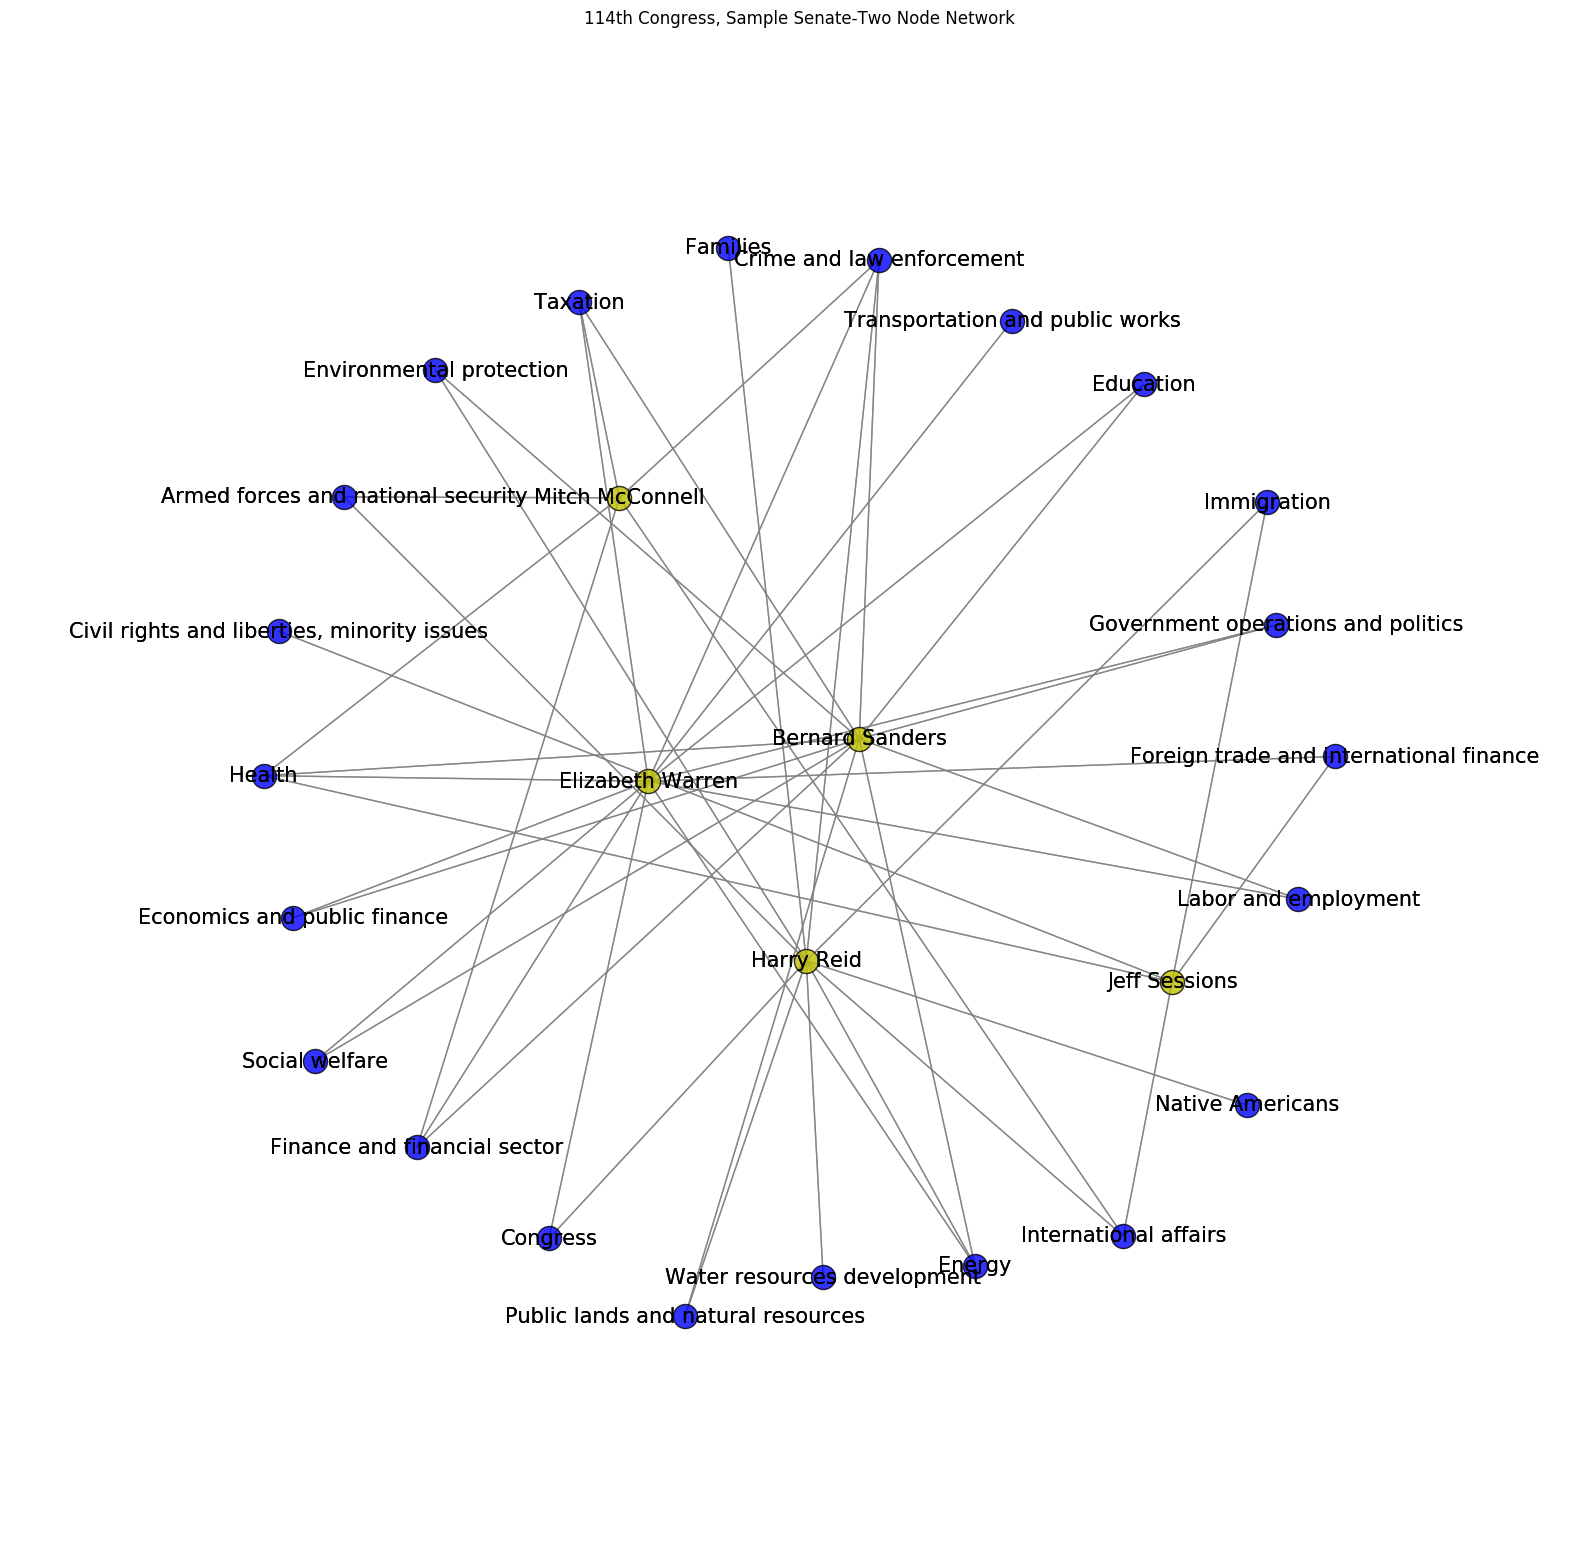

In [4]:
#Small subset data to show two-mode graph
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(subSetsenatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subSetsubjectList, bipartite=1)

for index, row in smallSubset.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.5, iterations=25)
nx.draw(B, nodelist = subSetsenatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subSetsubjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Sample Senate-Two Node Network')
plt.show()

Following is an entire two-mode graph showing a relationship between Senators and bill subjects. We will be working with the whole dataset for the rest of the project.

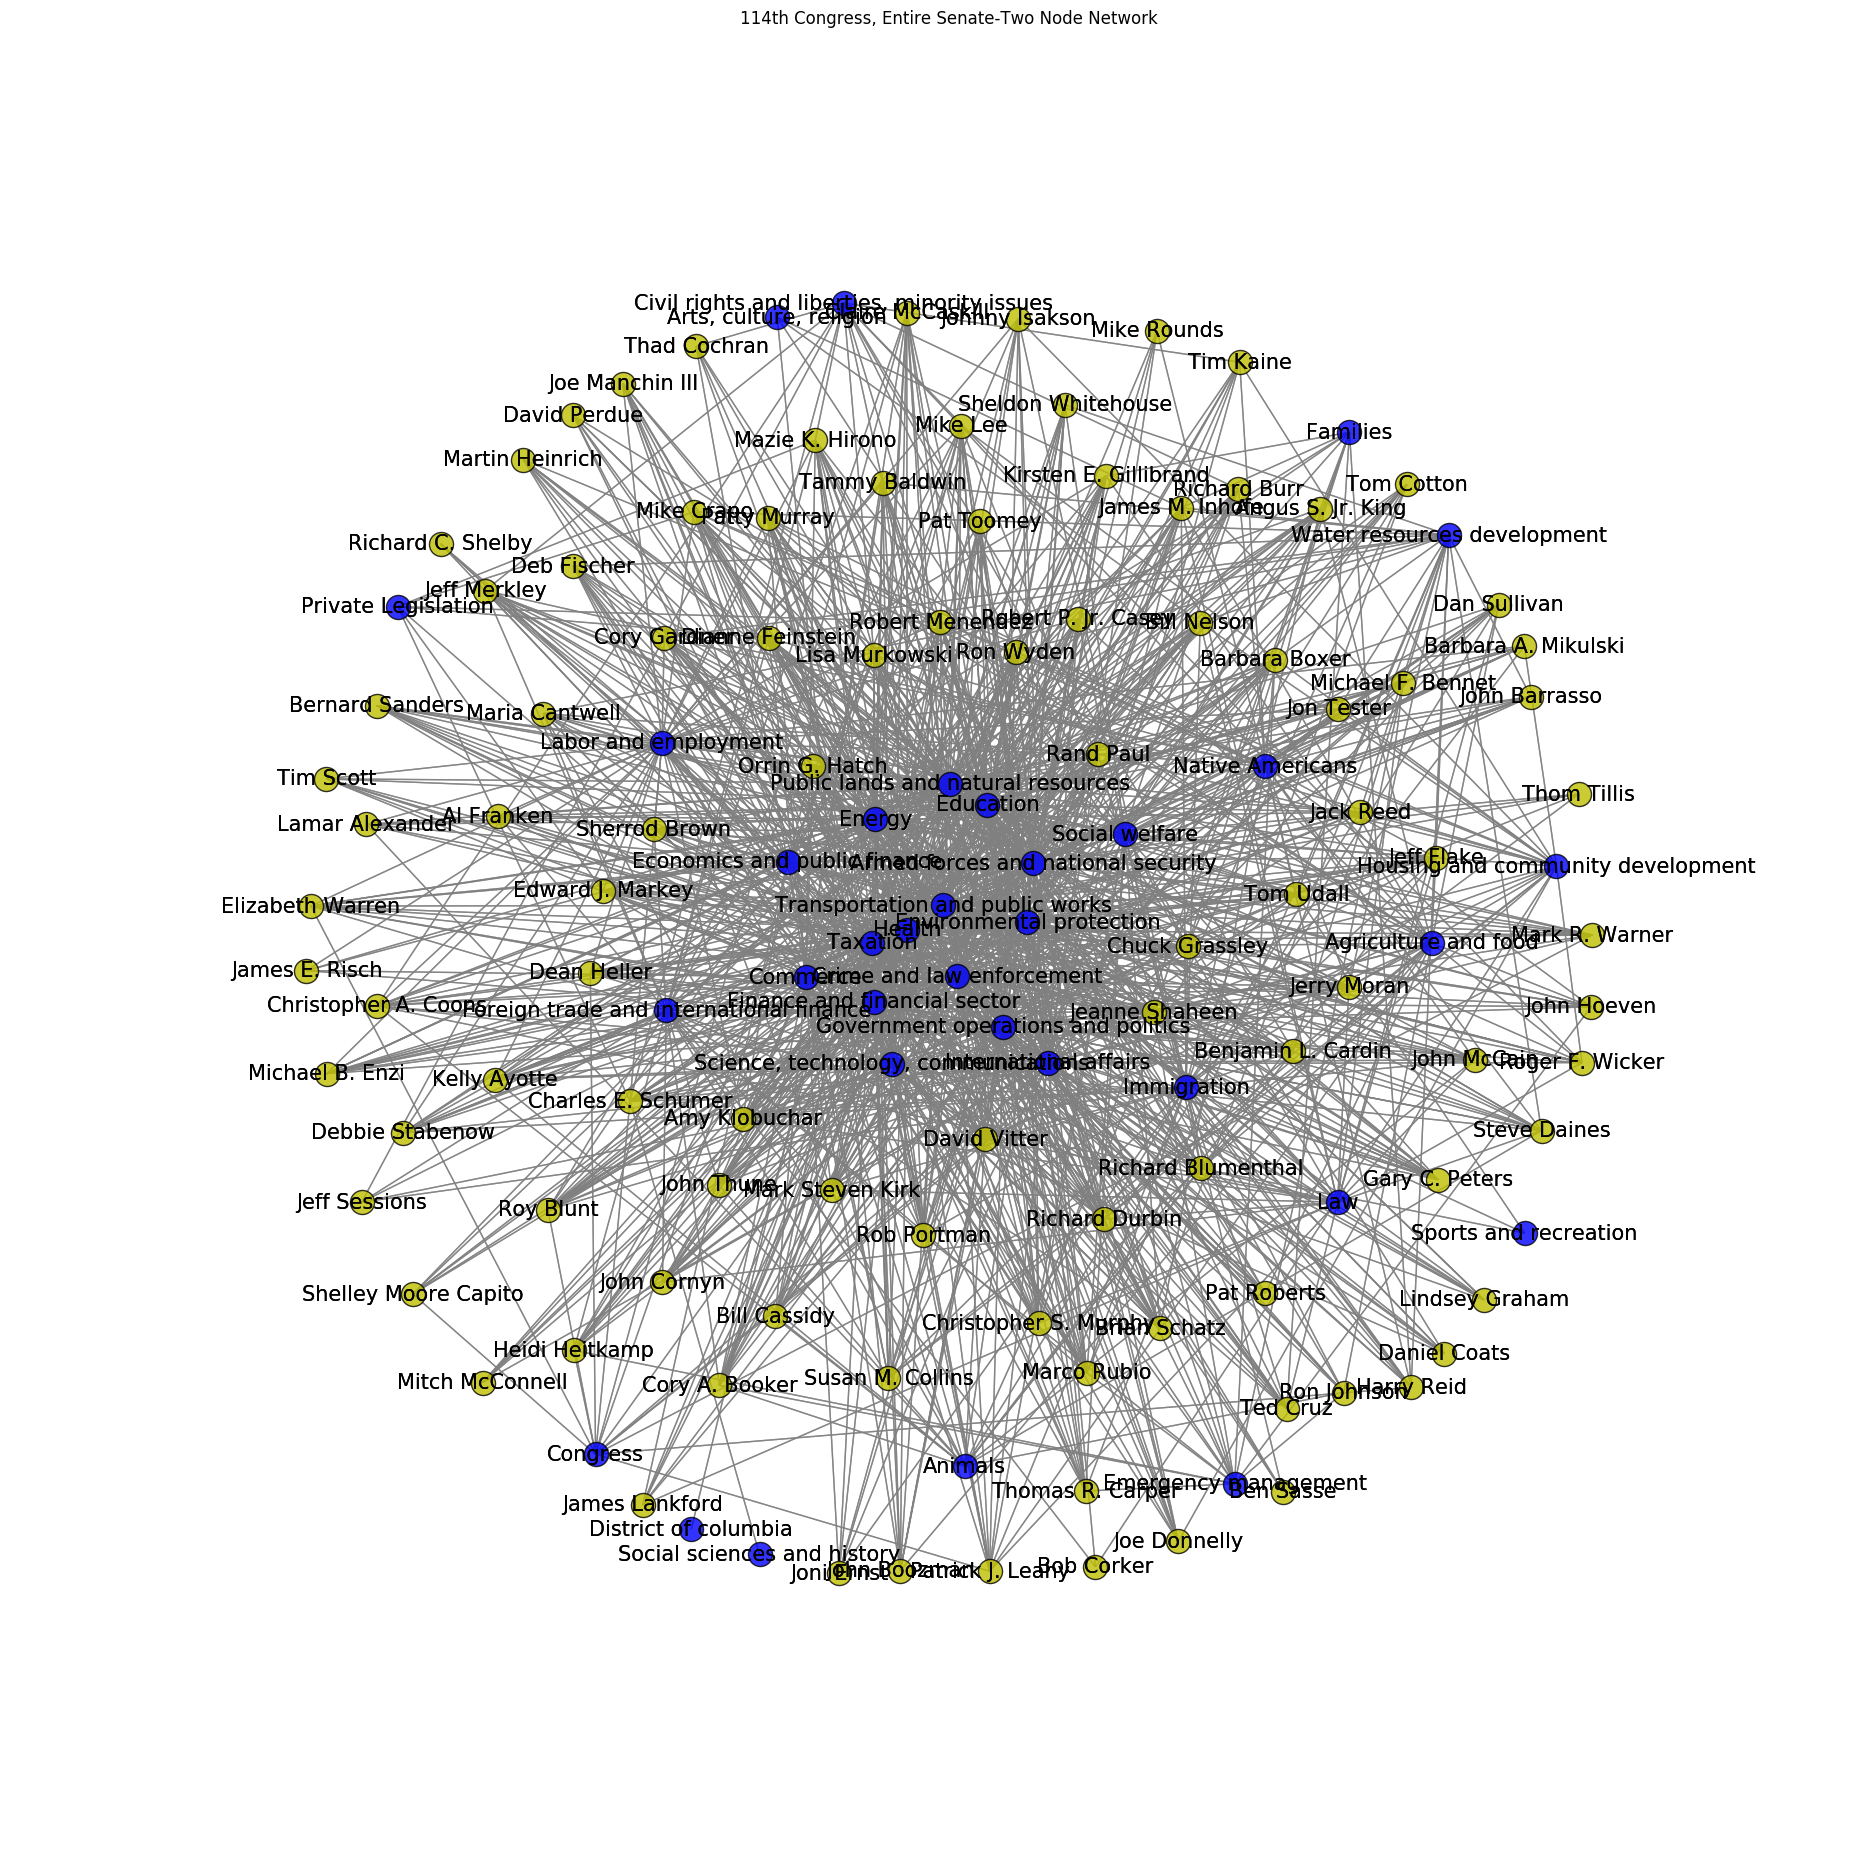

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(18, 18))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.3, iterations=75)
nx.draw(B, nodelist = senatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Entire Senate-Two Node Network')
plt.show()

Get information about node sets. There are 100 Senators and 34 bill subjects.

In [6]:
#Graph can be queried to get information about node sets
top_nodes, bottom_nodes = bipartite.sets(B)

#Total of 100 Senators
print (len(top_nodes))

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Subjects'])
df

34


Subjects
0            Armed forces and national security
1       Foreign trade and international finance
2                     Crime and law enforcement
3                          District of columbia
4            Government operations and politics
5                                        Energy
6   Civil rights and liberties, minority issues
7                       Arts, culture, religion
8                         International affairs
9                                       Animals
10           Public lands and natural resources
11                                     Congress
12                                  Immigration
13                                     Families
14          Science, technology, communications
15                 Finance and financial sector
16                  Social sciences and history
17                 Economics and public finance
18                     Environmental protection
19                                    Education
20                                          Law
21                         Labor and employment
22            Housing and community development
23                        Sports and recreation
24                  Water resources development
25                               Social welfare
26                             Native Americans
27                          Private Legislation
28                                       Health
29                         Agriculture and food
30                                     Commerce
31                         Emergency management
32              Transportation and public works
33                                     Taxation

In [7]:
#Total of 34 Bill Subjects
print (len(bottom_nodes))

#Bill Subjects
df = pd.DataFrame(list(bottom_nodes), columns=['Senators'])
df

100


Senators
0               Rand Paul
1          Jeanne Shaheen
2         Roger F. Wicker
3             John Hoeven
4              Bob Corker
5          James E. Risch
6          Heidi Heitkamp
7     Barbara A. Mikulski
8          Johnny Isakson
9          James Lankford
10        Michael B. Enzi
11           Cory Gardner
12         Mark R. Warner
13     Benjamin L. Cardin
14       Patrick J. Leahy
15            Marco Rubio
16            John Cornyn
17          Sherrod Brown
18             Tom Cotton
19          Jeff Sessions
20           John Boozman
21      Angus S. Jr. King
22           David Perdue
23           David Vitter
24            Thom Tillis
25       Thomas R. Carper
26            Ron Johnson
27           Brian Schatz
28            Rob Portman
29              Tom Udall
..                    ...
70         Lindsey Graham
71    Robert P. Jr. Casey
72         Chuck Grassley
73       Dianne Feinstein
74           Jeff Merkley
75           Dan Sullivan
76            Deb Fischer
77          Amy Klobuchar
78            Pat Roberts
79      Michael F. Bennet
80               Ted Cruz
81             Pat Toomey
82            John McCain
83        James M. Inhofe
84        Martin Heinrich
85         Orrin G. Hatch
86        Bernard Sanders
87        Mazie K. Hirono
88  Kirsten E. Gillibrand
89  Christopher S. Murphy
90          Barbara Boxer
91        Debbie Stabenow
92           Richard Burr
93          Tammy Baldwin
94            Dean Heller
95              Ron Wyden
96        Lamar Alexander
97           Patty Murray
98         Gary C. Peters
99         Maria Cantwell

[100 rows x 1 columns]

In [8]:
#Get total number of nodes in the graph (Senators + Bill Subjects)
bipartite.sets(B)
nx.number_of_nodes(B)

134

In [9]:
#Diameter of the graph. Total number of bill presented by Senators during 114th congress.
print(B.size())

1265


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 1 and bill subject bipartite value is 0
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

Node  bipartite
3                                     Al Franken          0
70                                 Amy Klobuchar          0
53                             Angus S. Jr. King          0
21                           Barbara A. Mikulski          0
101                                Barbara Boxer          0
22                                     Ben Sasse          0
68                            Benjamin L. Cardin          0
87                               Bernard Sanders          0
98                                  Bill Cassidy          0
18                                   Bill Nelson          0
11                                    Bob Corker          0
63                                  Brian Schatz          0
130                           Charles E. Schumer          0
88                          Christopher A. Coons          0
97                         Christopher S. Murphy          0
131                               Chuck Grassley          0
25                              Claire McCaskill          0
69                                Cory A. Booker          0
34                                  Cory Gardner          0
1                                   Dan Sullivan          0
103                                 Daniel Coats          0
57                                  David Perdue          0
58                                  David Vitter          0
114                                  Dean Heller          0
64                                   Deb Fischer          0
109                              Debbie Stabenow          0
48                              Dianne Feinstein          0
50                              Edward J. Markey          0
16                              Elizabeth Warren          0
126                               Gary C. Peters          0
..                                           ...        ...
90   Civil rights and liberties, minority issues          1
55                                      Commerce          1
86                                      Congress          1
2                      Crime and law enforcement          1
95                          District of columbia          1
100                 Economics and public finance          1
102                                    Education          1
14                          Emergency management          1
4                                         Energy          1
29                      Environmental protection          1
5                                       Families          1
93                  Finance and financial sector          1
65       Foreign trade and international finance          1
17            Government operations and politics          1
26                                        Health          1
105            Housing and community development          1
44                                   Immigration          1
13                         International affairs          1
60                          Labor and employment          1
116                                          Law          1
113                             Native Americans          1
42                           Private Legislation          1
83            Public lands and natural resources          1
92           Science, technology, communications          1
28                   Social sciences and history          1
41                                Social welfare          1
108                        Sports and recreation          1
115                                     Taxation          1
59               Transportation and public works          1
111                  Water resources development          1

[134 rows x 2 columns]

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric shows, bills sponsored by Senator Amy Klobuchar on subjects *Health* and *Science, technology, communications* make it to the floor faster compared to Senator Tom Cotton and Senator Tom Udall.

Example:
Minnesota Democratic Senator Amy Klobuchar has sponsored bills on subjects *Health* and *Science, technology, communications*. She and her staff have more experience than Arkansas Republican Senator Tom Cotton in getting these bills through committees and onto the Senate floor. If people of Arkansas want any legislation introduced related to *Health* and *Science, technology, communications* their chances of getting the bill onto the floor through Senator Amy Klobuchar are very high compared to   Senator Tom Cotton.

In [11]:
#Gives information about average shortest path between Senators and Subjects. 
#Every Senator has at least two subjects common with other Senators.
nx.average_shortest_path_length(B)

2.116934126360678

In [12]:
#Shortest path between Senators and bill subjects
#Value is close to average shortest path.
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 1)]
df2 = df[(df.bipartite == 0)]

cols = ['Subject', 'Senator', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Subject', 'Senator'], ascending = True, inplace=True)
ShortPath

Subject                Senator  ShortestPath
3352         Agriculture and food          Amy Klobuchar             1
3339         Agriculture and food      Angus S. Jr. King             1
3372         Agriculture and food  Christopher S. Murphy             1
3397         Agriculture and food         Chuck Grassley             1
3300         Agriculture and food           Dan Sullivan             1
3342         Agriculture and food           David Perdue             1
3343         Agriculture and food           David Vitter             1
3363         Agriculture and food        James M. Inhofe             1
3303         Agriculture and food         Jeanne Shaheen             1
3353         Agriculture and food             Jeff Flake             1
3358         Agriculture and food            Jerry Moran             1
3338         Agriculture and food           John Boozman             1
3305         Agriculture and food            John Hoeven             1
3369         Agriculture and food  Kirsten E. Gillibrand             1
3329         Agriculture and food         Lisa Murkowski             1
3390         Agriculture and food               Mike Lee             1
3356         Agriculture and food            Pat Roberts             1
3326         Agriculture and food       Patrick J. Leahy             1
3378         Agriculture and food           Patty Murray             1
3394         Agriculture and food     Richard Blumenthal             1
3379         Agriculture and food         Richard Durbin             1
3377         Agriculture and food        Robert Menendez             1
3341         Agriculture and food    Robert P. Jr. Casey             1
3304         Agriculture and food        Roger F. Wicker             1
3345         Agriculture and food            Ron Johnson             1
3321         Agriculture and food       Susan M. Collins             1
3349         Agriculture and food              Tom Udall             1
1850                      Animals     Benjamin L. Cardin             1
1873                      Animals           Bill Cassidy             1
1867                      Animals   Christopher A. Coons             1
...                           ...                    ...           ...
2919  Water resources development        Michael B. Enzi             3
2955  Water resources development      Michael F. Bennet             3
2990  Water resources development               Mike Lee             3
2959  Water resources development            Mike Rounds             3
2993  Water resources development        Mitch McConnell             3
2965  Water resources development         Orrin G. Hatch             3
2956  Water resources development            Pat Roberts             3
2961  Water resources development             Pat Toomey             3
2926  Water resources development       Patrick J. Leahy             3
2978  Water resources development           Patty Murray             3
2902  Water resources development              Rand Paul             3
2994  Water resources development     Richard Blumenthal             3
2981  Water resources development           Richard Burr             3
2940  Water resources development      Richard C. Shelby             3
2979  Water resources development         Richard Durbin             3
2948  Water resources development            Rob Portman             3
2977  Water resources development        Robert Menendez             3
2941  Water resources development    Robert P. Jr. Casey             3
2904  Water resources development        Roger F. Wicker             3
2945  Water resources development            Ron Johnson             3
2991  Water resources development              Roy Blunt             3
2935  Water resources development   Shelley Moore Capito             3
2922  Water resources development          Sherrod Brown             3
2921  Water resources development       Susan M. Collins             3
2957  Water resources development               Te

###Node centralities

We will be showing metrics

- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, *Health* and *Taxation* top the list in all three metrics. In other words, both subjects unite Senators closely than any other subject. Subject *District of Columbia* least popular among Senators.

In [13]:
#Closeness Betweenness Degrees centrality between Senetors and Subjects
close = nx.closeness_centrality(B)
between = nx.betweenness_centrality(B)
degree = nx.degree_centrality(B)
df1 = pd.DataFrame(list(close.items()), columns=['Node', 'Closeness'])
df2 = pd.DataFrame(list(between.items()), columns=['Node', 'Betweenness'])
df3 = pd.DataFrame(list(degree.items()), columns=['Node', 'Degrees'])
df = df1.join(df2.set_index('Node'), on='Node').join(df3.set_index('Node'), on='Node')
df.sort_values(['Closeness', 'Betweenness','Degrees'], ascending = False, inplace=True)
df

Node  Closeness  Betweenness  \
26                                        Health   0.692708     0.101990   
133                                     Taxation   0.651961     0.081904   
81            Public lands and natural resources   0.604545     0.064795   
66            Government operations and politics   0.599099     0.063533   
0             Armed forces and national security   0.588496     0.064645   
2                      Crime and law enforcement   0.545082     0.045923   
116              Transportation and public works   0.545082     0.042655   
100                                    Education   0.527778     0.035685   
56                                  David Vitter   0.523622     0.008982   
14                         International affairs   0.519531     0.046628   
90                  Finance and financial sector   0.515504     0.036473   
28                      Environmental protection   0.515504     0.033388   
67                                 Amy Klobuchar   0.515504     0.006491   
68                                    Jeff Flake   0.511538     0.006419   
7                                 Jeanne Shaheen   0.507634     0.006398   
80                                Orrin G. Hatch   0.507634     0.005318   
130                           Charles E. Schumer   0.503788     0.021357   
74                                      Mike Lee   0.503788     0.019391   
17                                     Tom Udall   0.503788     0.009767   
128                           Richard Blumenthal   0.503788     0.009606   
103                              Robert Menendez   0.503788     0.006964   
118                                    Ron Wyden   0.503788     0.005168   
106                               Richard Durbin   0.503788     0.004653   
65                                   Rob Portman   0.503788     0.004406   
82                              Mark Steven Kirk   0.503788     0.004089   
79                               James M. Inhofe   0.500000     0.008501   
114                                  Bill Nelson   0.500000     0.007933   
44                                    Mike Crapo   0.500000     0.006094   
57                              Dianne Feinstein   0.500000     0.005646   
37                                   Marco Rubio   0.500000     0.004304   
..                                           ...        ...          ...   
122                              Lamar Alexander   0.458621     0.000788   
47                          Shelley Moore Capito   0.458621     0.000670   
91                                  Thad Cochran   0.458621     0.000557   
29                               Mitch McConnell   0.458621     0.000255   
46                                 Jeff Sessions   0.449324     0.000474   
22                                     Ben Sasse   0.449324     0.000134   
98                  Economics and public finance   0.446309     0.015759   
73                                   Mike Rounds   0.446309     0.000284   
102                            Richard C. Shelby   0.446309     0.000151   
127                                  Immigration   0.443333     0.015822   
40                                Social welfare   0.443333     0.014690   
64       Foreign trade and international finance   0.437500     0.015152   
41                                   Thom Tillis   0.437500     0.000262   
13                                James E. Risch   0.437500     0.000176   
115                         Agriculture and food   0.423567     0.008114   
11                              Native Americans   0.420886     0.008903   
31                                           Law   0.418239     0.006880   
104            Housing and community development   0.413043     0.007747   
110                  Water resources development   0.407975     0.004550   
75                                       Animals   0.398204     0.003565   
84                                      Congress   0.393491     0.002552   
112  Civil right

###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

Following is the projected graph of Senators.

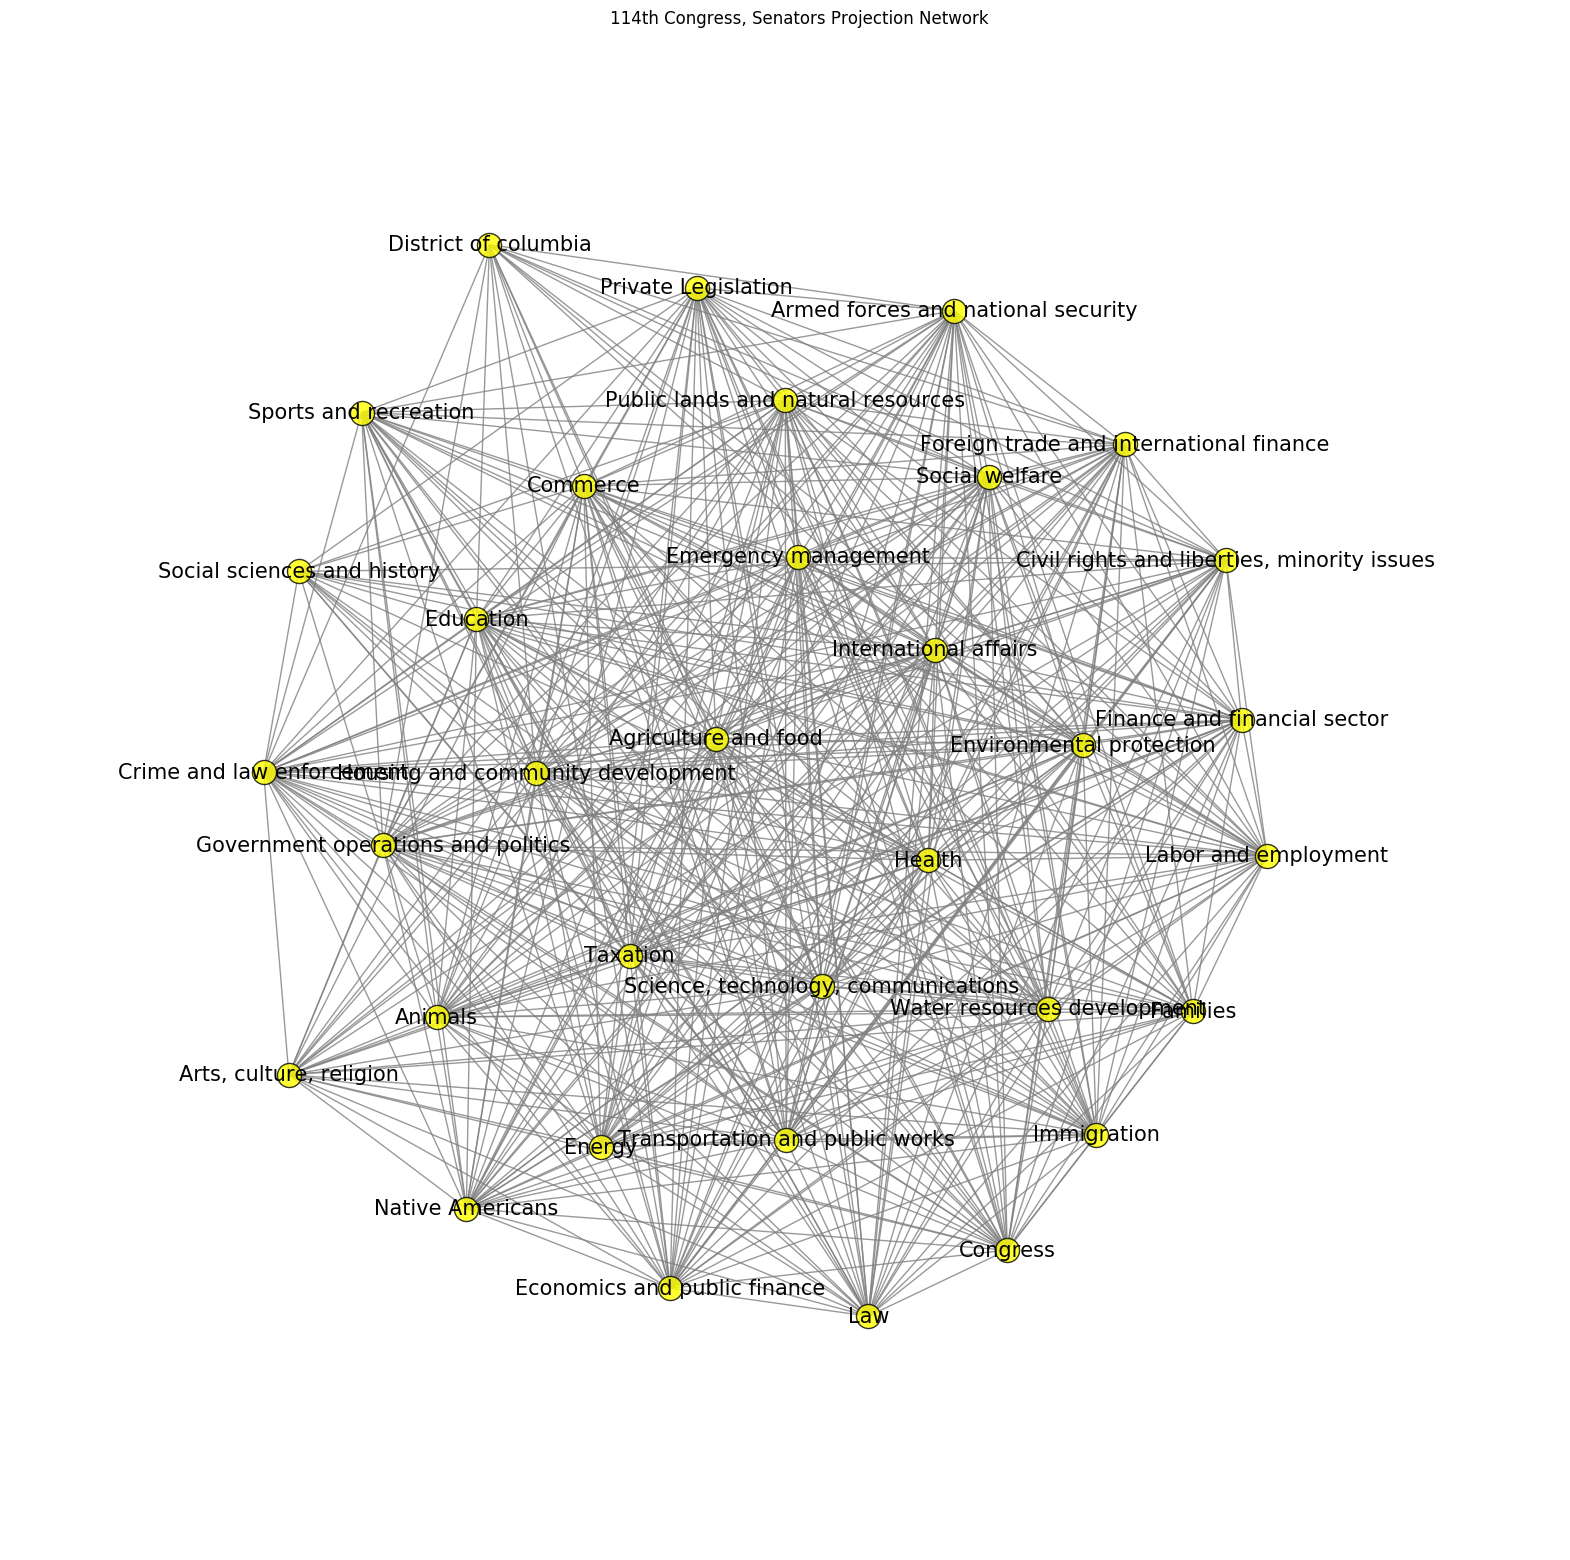

In [14]:
#Graph shows Senators are tightly connected.
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.6, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of bill subjects. 

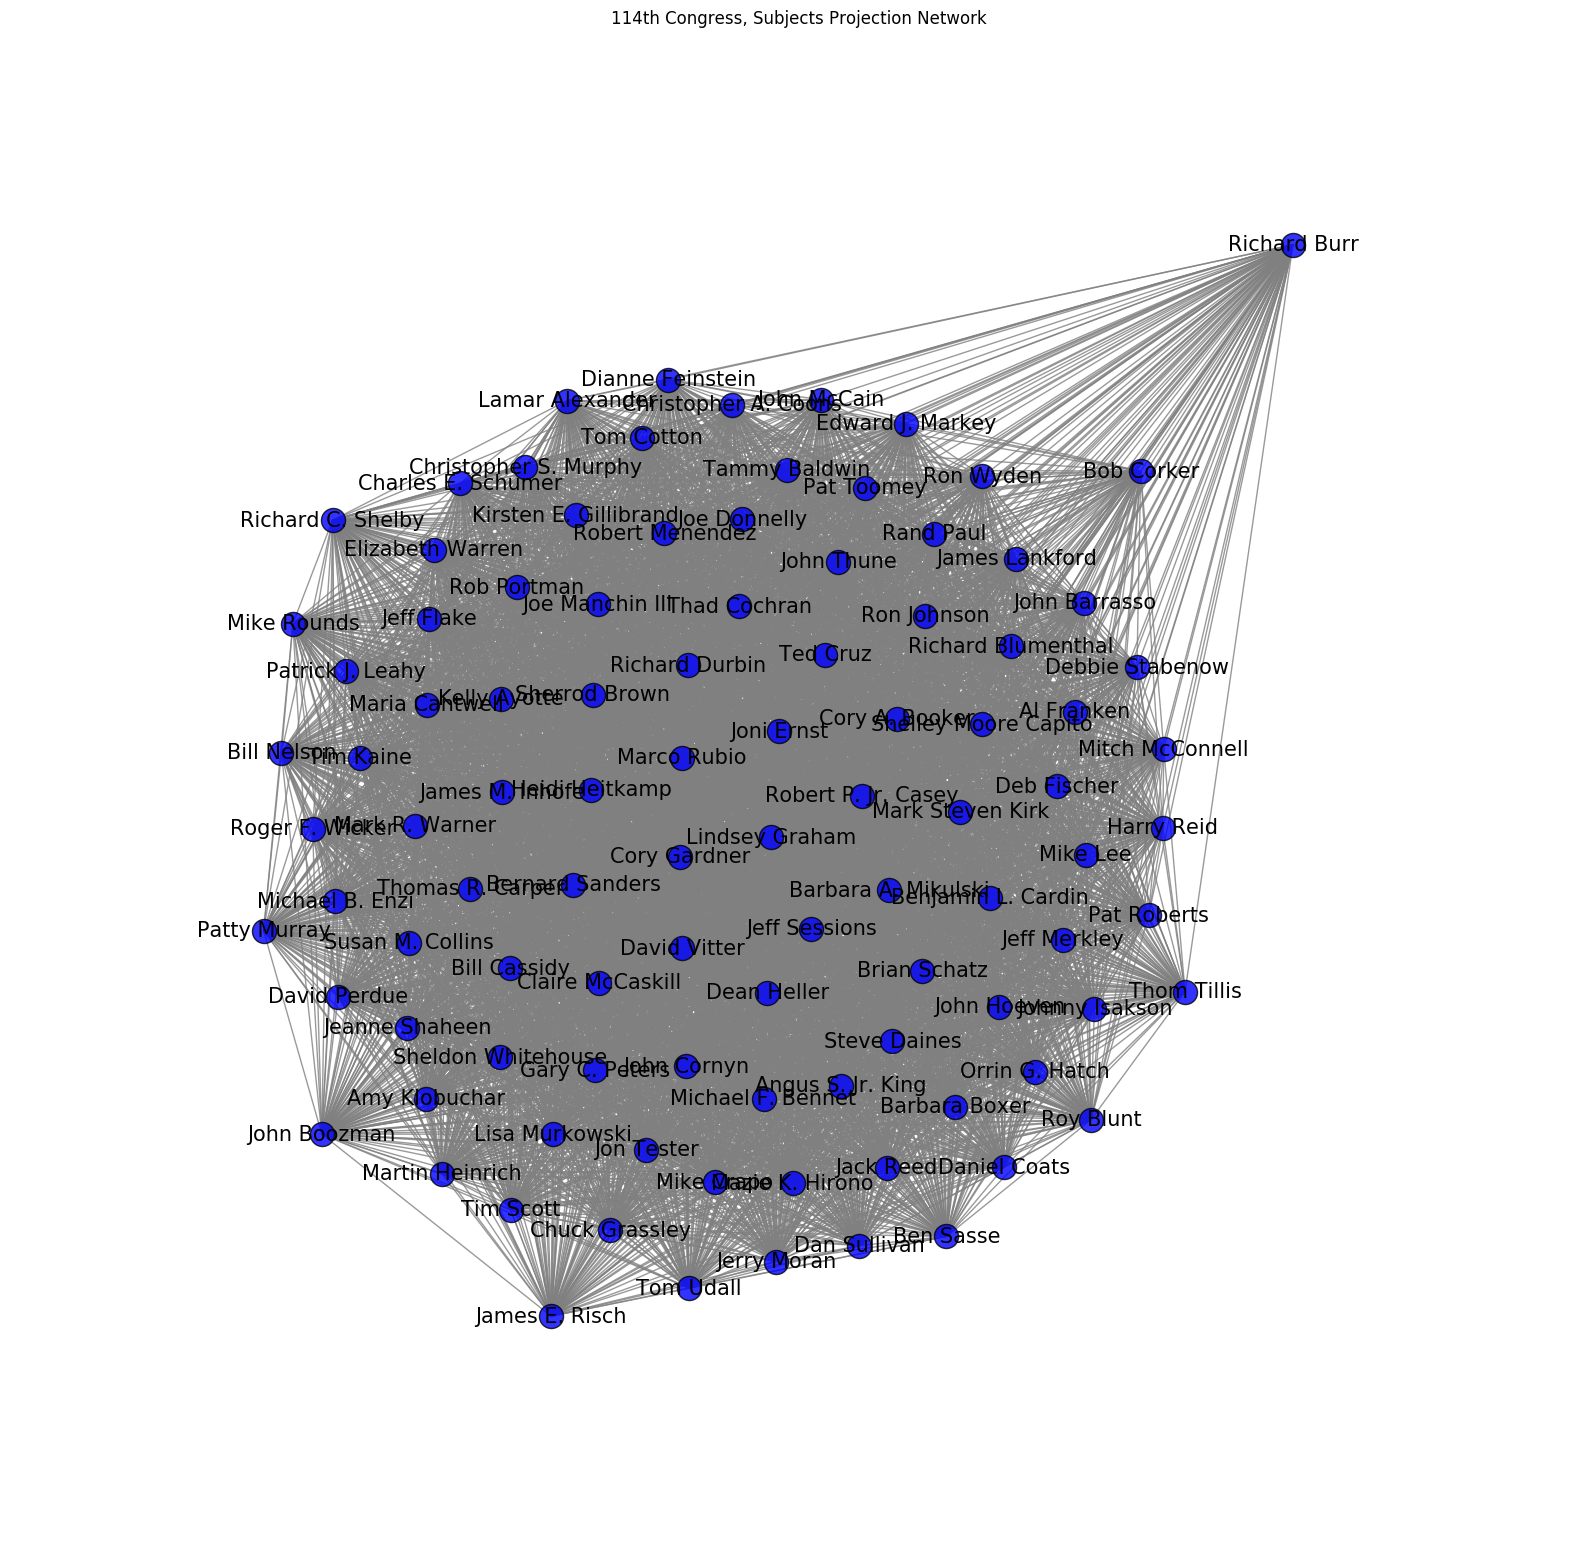

In [15]:
#Graph shows they are connected to the most part.
#Not all subjects are linked. Example: Social sciences & history and District of Columbia
#They were least popular among Senators

G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b')
plt.title('114th Congress, Subjects Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense. Output suggests it is not a dense graph.

In [16]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))

0.3720588235294118
0.3720588235294118


###Clustering

Two-mode clustering metrics show there is a high level of clustering around Senators Gary C. Peters, Senator Edward J. Markey and Senator Amy Klobuchar. In other words Senators are creating clusters around subjects. We can assume that Senators are more actively working on subjects.

In [17]:
c = bipartite.clustering(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
132                               Gary C. Peters    0.467979
48                              Edward J. Markey    0.466050
67                                 Amy Klobuchar    0.465132
65                                   Rob Portman    0.458394
82                              Mark Steven Kirk    0.457735
105                                 Patty Murray    0.449602
111                                Tammy Baldwin    0.443799
62                                  Brian Schatz    0.443223
80                                Orrin G. Hatch    0.438549
107                                    Roy Blunt    0.433688
99                                 Barbara Boxer    0.429799
18                                   Dean Heller    0.428701
118                                    Ron Wyden    0.428436
126                                 Kelly Ayotte    0.427624
106                               Richard Durbin    0.424544
88                         Kirsten E. Gillibrand    0.424226
38                                   John Cornyn    0.423339
56                                  David Vitter    0.422189
7                                 Jeanne Shaheen    0.421120
30                               Michael B. Enzi    0.416889
96                                  Bill Cassidy    0.415656
33                                  Cory Gardner    0.414451
72                                   Jerry Moran    0.406920
124                               Cory A. Booker    0.406413
93                                    John Thune    0.406024
85                               Bernard Sanders    0.404171
37                                   Marco Rubio    0.402996
94                         Christopher S. Murphy    0.402861
123                           Sheldon Whitehouse    0.398786
68                                    Jeff Flake    0.398304
..                                           ...         ...
24                                James Lankford    0.248444
129                                   Harry Reid    0.244810
55                                  David Perdue    0.236183
91                                  Thad Cochran    0.228641
98                  Economics and public finance    0.218295
40                                Social welfare    0.214168
127                                  Immigration    0.211763
31                                           Law    0.207037
115                         Agriculture and food    0.205080
13                                James E. Risch    0.201195
64       Foreign trade and international finance    0.200920
73                                   Mike Rounds    0.189306
22                                     Ben Sasse    0.185288
11                              Native Americans    0.174577
110                  Water resources development    0.169541
104            Housing and community development    0.167055
41                                   Thom Tillis    0.165161
102                            Richard C. Shelby    0.164930
46                                 Jeff Sessions    0.153204
75                                       Animals    0.148732
49                          Emergency management    0.145375
112  Civil rights and liberties, minority issues    0.126924
84                                      Congress    0.118515
23                                      Families    0.118401
12                                    Bob Corker    0.101726
42                           Private Legislation    0.082698
9                        Arts, culture, religion    0.053245
108                        Sports and recreation    0.042717
27                   Social sciences and history    0.032616
92                          District of columbia    0.025329

[134 rows x 2 columns]

###Local clustering coefficient for two-mode networks

Clustering values obtained using *Robins Alexander method* and *Global Average Method* differ because *Robins Alexander method* clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. Robins and Alexander defined a coefficient as the ratio between the number of 4-cycles and the number of 3-paths.

Whereas *Global Average Method* uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.

Reference: https://toreopsahl.com/tnet/two-mode-networks/clustering/

In [18]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.552
0.316


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [19]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                      node2  \
0      Armed forces and national security  Crime and law enforcement   
1      Armed forces and national security  Crime and law enforcement   
2      Armed forces and national security  Crime and law enforcement   
3      Armed forces and national security  Crime and law enforcement   
4      Armed forces and national security  Crime and law enforcement   
5      Armed forces and national security  Crime and law enforcement   
6      Armed forces and national security  Crime and law enforcement   
7      Armed forces and national security  Crime and law enforcement   
8      Armed forces and national security  Crime and law enforcement   
9      Armed forces and national security  Crime and law enforcement   
10     Armed forces and national security  Crime and law enforcement   
11     Armed forces and national security  Crime and law enforcement   
12     Armed forces and national security  Crime and law enforcement   
13     Armed forces and national security  Crime and law enforcement   
14     Armed forces and national security  Crime and law enforcement   
15     Armed forces and national security  Crime and law enforcement   
16     Armed forces and national security  Crime and law enforcement   
17     Armed forces and national security  Crime and law enforcement   
18     Armed forces and national security  Crime and law enforcement   
19     Armed forces and national security  Crime and law enforcement   
20     Armed forces and national security  Crime and law enforcement   
21     Armed forces and national security  Crime and law enforcement   
22     Armed forces and national security  Crime and law enforcement   
23     Armed forces and national security  Crime and law enforcement   
24     Armed forces and national security  Crime and law enforcement   
25     Armed forces and national security  Crime and law enforcement   
26     Armed forces and national security  Crime and law enforcement   
27     Armed forces and national security  Crime and law enforcement   
28     Armed forces and national security  Crime and law enforcement   
29     Armed forces and national security  Crime and law enforcement   
...                                   ...                        ...   
12902                      Maria Cantwell               Patty Murray   
12903                      Maria Cantwell         Richard Blumenthal   
12904                      Maria Cantwell         Richard Blumenthal   
12905                      Maria Cantwell         Richard Blumenthal   
12906                      Maria Cantwell               Richard Burr   
12907                      Maria Cantwell               Richard Burr   
12908                      Maria Cantwell              Tammy Baldwin   
12909                      Maria Cantwell              Tammy Baldwin   
12910                      Maria Cantwell              Tammy Baldwin   
12911                      Maria Cantwell             Orrin G. Hatch   
12912                      Maria Cantwell             Orrin G. Hatch   
12913                      Maria Cantwell             Orrin G. Hatch   
12914                      Maria Cantwell             Orrin G. Hatch   
12915                      Maria Cantwell                  Ron Wyden   
12916                      Maria Cantwell                  Ron Wyden   
12917                      Maria Cantwell                  Ron Wyden   
12918                      Maria Cantwell                  Ron Wyden   
12919                      Maria Cantwell                Thom Tillis   
12920                      Maria Cantwell         Sheldon Whitehouse   
12921                      Maria Cantwell         Sheldon Whitehouse   
12922                      Maria Cantwell         Sheldon Whitehouse   
12923                      Maria Cantwell                   Mike Lee   
12924                      Maria Cantwell                   Mike Lee   
12925                      Maria Cantwell                   Mike Lee   
1292

###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, bill subjects *Health* and *Taxation* ranked on the top. This explains Senator connecting to these bill subjects make a complete subgraph or a clique.

Bill subjects *Health* and *Taxation* connect more Senators, creating more cliques.

In [20]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
26                                    Health       88
133                                 Taxation       82
81        Public lands and natural resources       73
66        Government operations and politics       72
0         Armed forces and national security       71
116          Transportation and public works       61
2                  Crime and law enforcement       61
100                                Education       58
14                     International affairs       55
90              Finance and financial sector       55
28                  Environmental protection       54
4                                     Energy       51
119                                 Commerce       45
58                      Labor and employment       44
89       Science, technology, communications       42
98              Economics and public finance       36
40                            Social welfare       34
127                              Immigration       34
64   Foreign trade and international finance       32
11                          Native Americans       27
115                     Agriculture and food       27
31                                       Law       26
56                              David Vitter       23
110              Water resources development       22
104        Housing and community development       22
67                             Amy Klobuchar       21
68                                Jeff Flake       20
80                            Orrin G. Hatch       19
7                             Jeanne Shaheen       19
75                                   Animals       19
..                                       ...      ...
121                          Joe Manchin III       10
53                              Joe Donnelly       10
21                       Barbara A. Mikulski       10
3                                 Al Franken       10
32                                Tom Cotton        9
86                                 Tim Kaine        9
83                           Martin Heinrich        9
117                                Tim Scott        8
70                         Michael F. Bennet        8
95                            Lindsey Graham        8
122                          Lamar Alexander        8
78                              Daniel Coats        8
47                      Shelley Moore Capito        7
42                       Private Legislation        7
15                                Joni Ernst        7
24                            James Lankford        7
55                              David Perdue        7
91                              Thad Cochran        6
29                           Mitch McConnell        6
41                               Thom Tillis        5
73                               Mike Rounds        5
46                             Jeff Sessions        5
13                            James E. Risch        5
102                        Richard C. Shelby        4
22                                 Ben Sasse        4
9                    Arts, culture, religion        4
108                    Sports and recreation        3
12                                Bob Corker        3
27               Social sciences and history        1
92                      District of columbia        1

[134 rows x 2 columns]

However on a projected graph, bill subject *Transportation and public works* stand out.

In [21]:
G = bipartite.projected_graph(B, top_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
30              Transportation and public works        6
25          Science, technology, communications        6
20           Public lands and natural resources        6
19                        International affairs        6
26            Housing and community development        6
4            Government operations and politics        6
32                     Environmental protection        6
2                     Crime and law enforcement        6
22                                     Commerce        6
33                                     Taxation        5
12                               Social welfare        5
6                          Labor and employment        5
17                                  Immigration        5
16                                       Health        5
1       Foreign trade and international finance        5
27                 Finance and financial sector        5
3                                     Education        5
21                                     Congress        5
0            Armed forces and national security        5
18                         Agriculture and food        5
11                  Water resources development        4
9                              Native Americans        4
13                                          Law        4
5                                        Energy        4
31                 Economics and public finance        4
15                          Private Legislation        3
7   Civil rights and liberties, minority issues        3
14                                      Animals        3
24                                     Families        2
23                         Emergency management        2
10                        Sports and recreation        1
29                  Social sciences and history        1
28                         District of columbia        1
8                       Arts, culture, religion        1

On a projected graph, following table, shows subgroups among bill subjects. These subjects are more popular among Senators and bills connected to these subjects tend to make it floor more often.

In [22]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1  \
0     Armed forces and national security   
1     Armed forces and national security   
2     Armed forces and national security   
3     Armed forces and national security   
4     Armed forces and national security   
5     Armed forces and national security   
6     Armed forces and national security   
7     Armed forces and national security   
8     Armed forces and national security   
9     Armed forces and national security   
10    Armed forces and national security   
11    Armed forces and national security   
12    Armed forces and national security   
13    Armed forces and national security   
14    Armed forces and national security   
15    Armed forces and national security   
16    Armed forces and national security   
17    Armed forces and national security   
18    Armed forces and national security   
19    Armed forces and national security   
20    Armed forces and national security   
21    Armed forces and national security   
22    Armed forces and national security   
23    Armed forces and national security   
24    Armed forces and national security   
25    Armed forces and national security   
26    Armed forces and national security   
27    Armed forces and national security   
28    Armed forces and national security   
29    Armed forces and national security   
...                                  ...   
5115            Environmental protection   
5116            Environmental protection   
5117            Environmental protection   
5118            Environmental protection   
5119            Environmental protection   
5120            Environmental protection   
5121            Environmental protection   
5122            Environmental protection   
5123            Environmental protection   
5124            Environmental protection   
5125            Environmental protection   
5126            Environmental protection   
5127            Environmental protection   
5128            Environmental protection   
5129            Environmental protection   
5130            Environmental protection   
5131            Environmental protection   
5132            Environmental protection   
5133            Environmental protection   
5134            Environmental protection   
5135            Environmental protection   
5136            Environmental protection   
5137            Environmental protection   
5138            Environmental protection   
5139            Environmental protection   
5140            Environmental protection   
5141            Environmental protection   
5142            Environmental protection   
5143            Environmental protection   
5144                            Taxation   

                                        node2  \
0     Foreign trade and international finance   
1     Foreign trade and international finance   
2     Foreign trade and international finance   
3     Foreign trade and international finance   
4     Foreign trade and international finance   
5     Foreign trade and international finance   
6     Foreign trade and international finance   
7     Foreign trade and international finance   
8     Foreign trade and international finance   
9     Foreign trade and international finance   
10    Foreign trade and international finance   
11    Foreign trade and international finance   
12    Foreign trade and international finance   
13    Foreign trade and international finance   
14    Foreign trade and international finance   
15    Foreign trade and international finance   
16                  Crime and law enforcement   
17                  Crime and law enforcement   
18                  Crime and law enforcement   
19                  Crime and law enforcement   
20                  Crime and law enforcement   
21                  Crime and law enforcement   
22                  Crime and law enforcement   
23                  Crime and law enforcement   
24                  Crime and law enforcement   
25                  Crime and la

###Final Analysis

- Senators presenting most bills
- Subjects on which most bills are presented.

We will be using *island method* from chapter 4 of *Social Network Analysis for Startups*

In [23]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
        
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
cc = max(nx.connected_component_subgraphs(B), key=len)
islands=island_method(cc)

Analysis: 

- When every Senator presents one bill on any of 34 subjects; network separates into 129 nodes and 129 islands.
- When the water level is raised 6 units, meaning removing Senators from the network who present less than 6 bills, network separates into 73 nodes and 73 islands.
- When the water level is raised 11 units, meaning removing Senators from the network who present less than 11 bills, network separates into 21 nodes and 3 islands. The first island has 7 nodes, the second island has 6 nodes and third has 8 nodes.
- When the water level is raised 21 units, meaning removing Senators from the network who present less than 21 bills, network separates into 4 nodes and 2 islands. Both islands have 2 nodes each.
- When the water level is raised the highest possible level, meaning removing Senators from the network who present less than 26 bills, network separates into 2 nodes and single island. This combination represents Senator presenting most bills and popular subject.


In [24]:
print ('%-25s %-45s %-13s' % ('Number of Bills', 'Nodes(Senetors + Subjects)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))

Number of Bills           Nodes(Senetors + Subjects)                    Islands      
1                         129                                           [129]        
6                         73                                            [73]         
11                        21                                            [6, 7, 8]    
16                        8                                             [3, 3, 2]    
21                        4                                             [2, 2]       
26                        2                                             [2]          


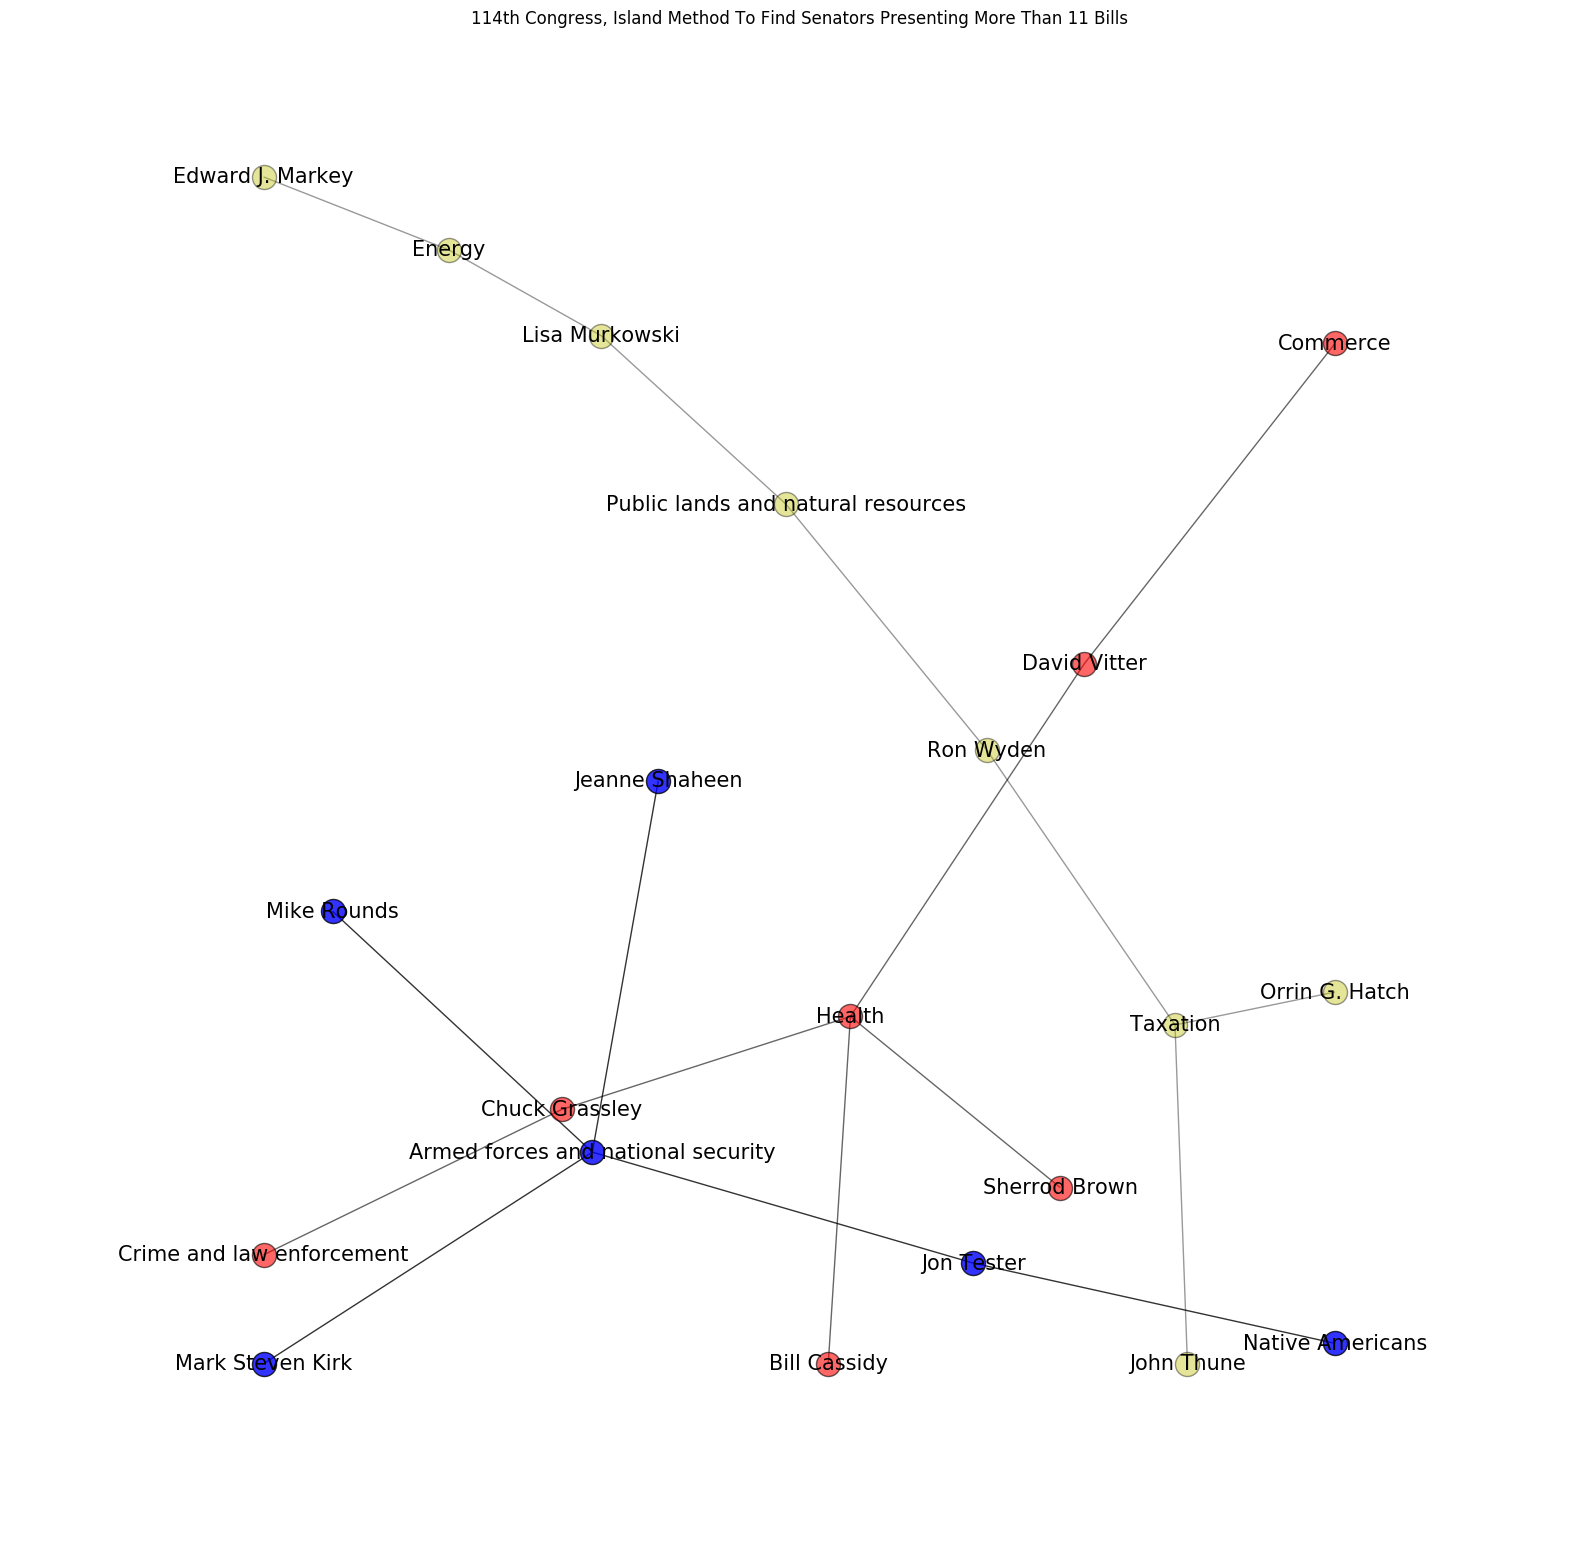

In [25]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 11:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('114th Congress, Island Method To Find Senators Presenting More Than 11 Bills')
plt.show()


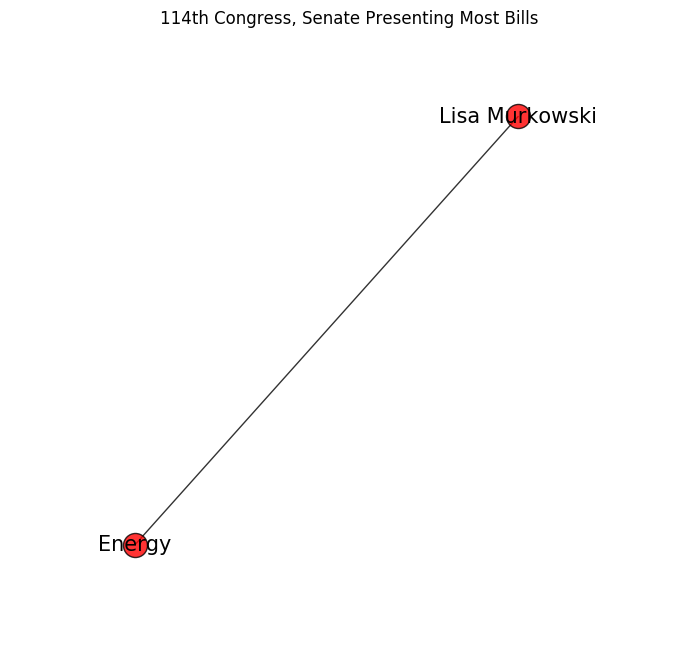

In [26]:
#Senetor presenting most bills on popular subject
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(6, 6))

for i in islands:
    if i[0] == 26:
        for c in nx.connected_component_subgraphs(i[1]):
            nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'r')
            
plt.title('114th Congress, Senate Presenting Most Bills')
plt.show()